## Introduction
This notebook presents a simple example of an ODE problem that I know can be solved as is. I would like to solve it in its 'inverse' form -- theoretically this is the same function, but I am struggling to get it working.

In [1]:
using JuMP
using Ipopt
using DataFrames, CSV
using Parameters
using DifferentialEquations
using Distributions
using NLsolve
using Plots
using SpecialFunctions


using ForwardDiff

### The following are "helper functions". They are unchanged between the two versions

In [2]:
mutable struct Bid{T1,T2,T3,T4}
    init_index::Int64
    a::T1
    b::T2
    q::T3
    a_over_q::T4
end

function quadprog_fastSolve(a,b,q, s)
    num_bids = length(a)
    bidvec = [Bid(i, a[i],b[i],q[i],(a[i]/q[i])) for i=1:num_bids]

    sorted_bids = sort(bidvec, by = x -> x.a_over_q, rev=true)
    
    function x_star(bid, v)
        out = (bid.a + v * bid.q)/(2*bid.b) 
    end

    function v_k_star(k_plus_one)
        include = [i < k_plus_one ? 1 : 0 for i=1:num_bids]
        sum_1 = sum( include[i] * (sorted_bids[i].a * sorted_bids[i].q)/(sorted_bids[i].b)  for i=1:num_bids)
        sum_2 = sum( include[i] * (sorted_bids[i].q * sorted_bids[i].q)/(sorted_bids[i].b)  for i=1:num_bids)
        out_temp = sum(include) > 0 ? (2*s - sum_1)/sum_2 : 0
        out = k_plus_one <= num_bids ? min(out_temp, -sorted_bids[k_plus_one].a_over_q) : out_temp
        return(out)
    end

    function dual_eval(v)
        include = [-bid.a_over_q <= v ? 1 : 0 for bid in sorted_bids]
        x_stars = [include[i]*x_star(sorted_bids[i], v) for i=1:num_bids]
        out = sum( include[i] * ((sorted_bids[i].a + v*sorted_bids[i].q)^2/(4*sorted_bids[i].b) ) for i=1:num_bids) - v*s
        return(out, x_stars)
    end
        
    v_ks = [v_k_star(k) for k=1:(num_bids+1)]
    duals = [dual_eval(v_k) for v_k in v_ks]
    
    sort!(duals, by = x -> x[1])
    
    opt = duals[1]
    x_star_sorted = opt[2]
    x_star_orig_order = copy(x_star_sorted)
    for i = 1:num_bids
        bid = sorted_bids[i]
        x_star_orig_order[bid.init_index] = x_star_sorted[i]
    end
    
   return(x_star_orig_order)   
    
end



quadprog_fastSolve (generic function with 1 method)

In [3]:
## Helper Functions

function getCE(gamma, alpha, s, q_b, q_e , c, sigma_sq)
    b = getBidVec( gamma, alpha, s, q_b, q_e , c, sigma_sq)    

    b_min_c = b - (alpha*c);

    ce = (q_b' * b_min_c) - (gamma/2) * ((sigma_sq .* b_min_c)' * b_min_c)
end

function getBoundarySMax(alpha_max, gamma, q_b, q_e , c, sigma_sq)
    function ce_fun(svec)
        s_max_var = svec[1]
        return getCE(gamma, alpha_max, s_max_var, q_b, q_e , c, sigma_sq) 
    end
    starting_point = alpha_max*1.01*(c' * q_b)

    s_max_sol = nlsolve(ce_fun, [starting_point]; inplace = false)
    return s_max_sol.zero[1]
end



function getBidVec( gamma, alpha, s, q_b, q_e , c, sigma_sq)
    # Compute the optimal unit bid vector for each score by solving the quadratic optimization problem
    T = length(q_e)
    if sum(sigma_sq) > 0

        m = Model(Ipopt.Optimizer)
        set_optimizer_attribute(m, "print_level", 0)

        @variables m begin
        b[i=1:T] >= 0
        end

        @objective( m,
                    Max,
                    (sum((q_b[i] * (b[i] - alpha*c[i]) - (gamma / 2) * sigma_sq[i] * (b[i] - alpha*c[i])^2) for i=1:T ))
                 )

              @constraint(m, sum( b[i] * q_e[i] for i=1:T ) == s)

           optimize!(m)

           b_min = value.(b)
   else
       (maxitem,maxindex) = findmax(q_b./q_e)
       b_min = zeros(T)
       b_min[maxindex] = s/q_e[maxindex]
   end

    return b_min

end

function getOptimalBids_quadprog(gamma, alpha, s, q_b, q_e , c, sigma_sq)
    
    T = length(q_e)
    
    
    b_tilde =  (gamma * 0.5) * sigma_sq 
    a_tilde = (q_b + (gamma * alpha * c) .* sigma_sq)
    s_tilde = s
    q_tilde = q_e
    
    sol = quadprog_fastSolve(a_tilde,b_tilde,q_tilde,s_tilde)
    
    return(sol)
end



function getDbDs(gamma, alpha, b, q_b, q_e , c, sigma_sq)
#     %Computes anayltical derivative of the optimal bid function of item t
#     % w.r.t. score s given alpha

    T = length(q_e)
    pos_b = [ifelse(b[t] > 0, 1, 0) for t=1:T]

    if (sum(sigma_sq) > 0)
        denom = 1.0/(sum((q_e[t]^2 * pos_b[t]) / sigma_sq[t] for t in 1:T))
        db_ds = [((q_e[t] * pos_b[t] / sigma_sq[t]) * denom) for t in 1:T]'
    else
        db_ds = [ifelse(b[t] > 0, (1.0/q_e[t]), 0) for t=1:T]'
    end

    return(db_ds)

end

function f_over_one_minus_F_uniform(z, a, b)
    if z <= a 
        out = 0
    elseif z >= b
        out = 0
    else 
        out =  1.0/(b - z) 
    end
end


f_over_one_minus_F_uniform (generic function with 1 method)

### Here is the "frontward" ODE (that works -- uncomment the print line to see du)

In [175]:
function f_over_one_minus_F_truncated_lognormal(z, mu, sigma, a, b)
    
    if z < a
        out_fin = 0
    elseif z > b
        out_fin = 0
    else 
        out = 0.5*sqrt(2)*sqrt(pi)*sigma*z
        out = out * (-erf(sqrt(2)*(mu - log(b))/(2*sigma)) + 1.0*erf(sqrt(2)*(mu - log(z))/(2*sigma)))
        out = out * exp((mu - log(z))^2/(2*sigma^2))
        out_fin = 1.0/(out - 0.0000001)

    end
    return(out_fin)
end

function ds_da_ode( s, alpha, gamma, c, q_e, q_a, sigma_sq ) ## By the way, I couldn't get an in-place formulation of this to work
                                                                ##  (see the end of the notebook -- not my main problem though)
#     b = getBidVec( gamma, alpha, s, q_a, q_e , c, sigma_sq)
    b = getOptimalBids_quadprog( gamma, alpha, s, q_a, q_e , c, sigma_sq)
    db_ds = getDbDs( gamma, alpha, b, q_a, q_e , c, sigma_sq)

    
    b_min_c = b - (alpha*c);

    profit_ce = (q_a' * b_min_c) - (gamma)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
    profit_term = exp(gamma*profit_ce) - 1;

    f_over_oneMinusF = f_over_one_minus_F_truncated_lognormal(alpha, 0.0, 0.2, 0.49999, 2.0)
#     f_over_one_minus_F_uniform(alpha, 0.49999, 2.0)

    dce = db_ds * ((gamma .* q_a) - (gamma^2 .* sigma_sq .* b_min_c) );
    
    ds_da = f_over_oneMinusF * profit_term / dce; # Note: this should be a scalar
#     println("ds_da: ", ds_da)
    
    return(ds_da)

end


ds_da_ode (generic function with 1 method)

### Simple Numerical Example

In [176]:
qa = [12; 40];
qe = [10; 50];
c = [5;10];
sigmasq = [3, 5];
gamma_in = 1.5;

alpha_max = 2;
alpha_min = 0.5;

alpha_span = (alpha_max,alpha_min);

s_max_computed = getBoundarySMax(alpha_max, gamma_in, qa, qe , c, sigmasq)

ode_forward_subs(s, p, alpha) = ds_da_ode( s, alpha, gamma_in, c, qe, qa, sigmasq )
ode_forward_prob = ODEProblem(ode_forward_subs, s_max_computed, alpha_span)

# sol_forward =  DifferentialEquations.solve(ode_forward_prob, Rosenbrock23(autodiff=false))

sol_forward =  DifferentialEquations.solve(ode_forward_prob, Rodas5())


retcode: Success
Interpolation: 3rd order Hermite
t: 22-element Array{Float64,1}:
 2.0               
 1.9999            
 1.999724668968573 
 1.9995331877374696
 1.9990868606922805
 1.9983311004641253
 1.9969264021989896
 1.9943503018208313
 1.990391909283763 
 1.9851010092798889
 1.977384520192521 
 1.966426537087979 
 1.9506384967693815
 1.92784276710838  
 1.8946043460676212
 1.8455805849823523
 1.7722037880571413
 1.6603249319702962
 1.4853036503812322
 1.2011372988164501
 0.7518144365536656
 0.5               
u: 22-element Array{Float64,1}:
 1097.9867070962464
 1097.9328228021125
 1097.8999466566283
 1097.8493801694449
 1097.7197806175943
 1097.4822751889226
 1096.9940402556354
 1095.9715118457093
 1094.1915737820268
 1091.6144259600355
 1087.678954806131 
 1081.9321847696608
 1073.5057455981844
 1061.1994403499896
 1043.1205523546987
 1016.3254151679928
  976.0980911644151
  914.6616337957447
  818.4949552895438
  662.4238733697896
  416.7162882204176
  282.0071384722943

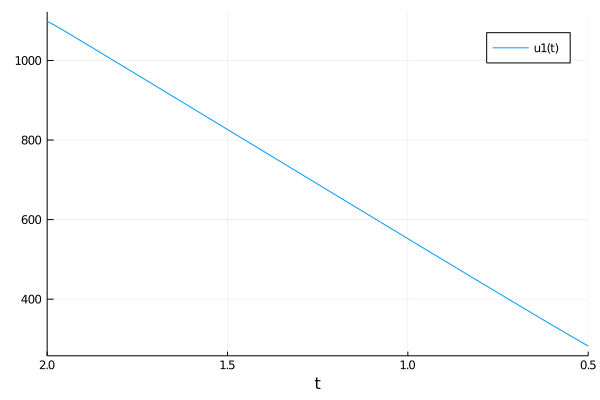

In [177]:
plot(sol_forward)

## Now I'd like to solve the "inverse" of this ODE -- da_ds instead of ds_da 
### (I need this for a more complex version of the problem)

In [38]:
mutable struct Lock_Inst{T0,T1,T2,T3,T4,T5}
    s::T0
    alpha::T1
    profit_ce::T2
    profit_term::T3
    f_term::T4
    da_ds::T5
end

In [106]:
function f_over_one_minus_F_uniform(z, a, b)
    if z <= a 
        out = 0
    elseif z >= b
        out = 0
    else 
        out =  1.0/(b - z) 
    end
end

function one_minus_F_over_f_uniform(z, a, b)
    if z <= a 
        out = 0
    elseif z >= b
        out = 0
    else 
        out =  (b - z) 
    end
end

function inverse_ds_da_ode( s, alpha, params)
    
    gamma, c, q_e, q_a, sigma_sq  = params
    
#     println("alpha: ", alpha, "; s: ", s)
    b = getOptimalBids_quadprog( gamma, alpha, s, q_a, q_e , c, sigma_sq)
    db_ds = getDbDs( gamma, alpha, b, q_a, q_e , c, sigma_sq)

    b_min_c = b - (alpha*c);

    profit_ce = (q_a' * b_min_c) - (gamma)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
    profit_term = exp(gamma*profit_ce) - 1;
    
#     println("profit_term: ", profit_term)

#     f_over_oneMinusF = f_over_one_minus_F_uniform(alpha, 0.49999, 2.0)
    oneMinusF_over_f = one_minus_F_over_f_uniform(alpha, 0.49999, 2.0)
    
#     println("f_over_oneMinusF: ", f_over_oneMinusF)
    
    dce = db_ds * ((gamma .* q_a) - (gamma^2 .* sigma_sq .* b_min_c) );
    
#     println("dce: ", dce)
        
    da_ds = profit_term < 0.001 ? 1e-12 : (dce*oneMinusF_over_f)/profit_term
    
#     println("da_ds: ", da_ds)
        
    return(da_ds)

end

inverse_ds_da_ode (generic function with 2 methods)

In [111]:
s_min_from_forward_solve = 278.59059248983635

alpha_init = alpha_min 

s_span = (s_min_from_forward_solve, s_max_computed)

params_in = [gamma_in, c, qe, qa, sigmasq, lock_in]

ode_backward_subs(alpha, p, s) = inverse_ds_da_ode( s, alpha, params_in )
ode_backward_prob = ODEProblem(ode_backward_subs, alpha_init, s_span)

sol_backward =  DifferentialEquations.solve(ode_backward_prob,
                                            Rodas4P()
                                            )



retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 136934-element Array{Float64,1}:
  278.59059248983635
  278.81964903704716
  281.11021450915507
  285.41305154605584
  286.14574689614295
  287.76794687259445
  288.5744255196246 
  288.73344108786887
  288.7785800963375 
  288.81312690531445
  288.82968596099244
  288.8347198183033 
  288.8381633970804 
    ⋮               
 1088.6056095367344 
 1088.605857301117  
 1088.6059471062747 
 1088.6068451578512 
 1088.607575736688  
 1088.6080733391582 
 1088.6130493638598 
 1088.6628096108745 
 1089.1604120810227 
 1094.1364367825054 
 1096.27042167802   
 1097.9867070962464 
u: 136934-element Array{Float64,1}:
 0.5               
 0.5004168786396835
 0.5045856549964272
 0.5124419836518944
 0.5138129339219494
 0.5171351027300246
 0.5200314707087853
 0.5215027906749119
 0.5223244233124561
 0.5235021034687757
 0.5247972760092506
 0.525655306064015 
 0.5270782310702318
 ⋮                 
 1.98294206

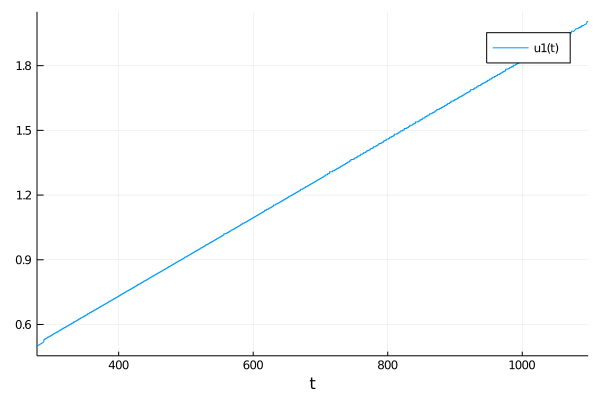

In [112]:
plot(sol_backward)

In [225]:


function one_minus_F_over_f_truncated_lognormal(z, mu, sigma, a, b)
    
    if z < a
        out_fin = 0
    elseif z > b
        out_fin = 0
    else 
        out = 0.5*sqrt(2)*sqrt(pi)*sigma*z
        out = out * (-erf(sqrt(2)*(mu - log(b))/(2*sigma)) + 1.0*erf(sqrt(2)*(mu - log(z))/(2*sigma)))
        out = out * exp((mu - log(z))^2/(2*sigma^2))
        out_fin = out

    end
    return(out_fin)
end

function inverse_ds_da_ode( s, alpha, params)
    
    gamma, c, q_e, q_a, sigma_sq  = params
    
#     println("alpha: ", alpha, "; s: ", s)
    b = getOptimalBids_quadprog( gamma, alpha, s, q_a, q_e , c, sigma_sq)
    db_ds = getDbDs( gamma, alpha, b, q_a, q_e , c, sigma_sq)

    b_min_c = b - (alpha*c);

    profit_ce = (q_a' * b_min_c) - (gamma)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
    profit_term = exp(gamma*profit_ce) - 1;
    
#     println("profit_term: ", profit_term)

    oneMinusF_over_f = one_minus_F_over_f_truncated_lognormal(alpha, 0.0, 0.2, 0.49999, 2.0)
        
#     println("f_over_oneMinusF: ", f_over_oneMinusF)
    
    dce = db_ds * ((gamma .* q_a) - (gamma^2 .* sigma_sq .* b_min_c) );
    
    da_ds = profit_term < 0.001 ? 1e-12 :  (dce*oneMinusF_over_f)/profit_term
    
#     println("da_ds: ", da_ds)
        
    return(da_ds)

end

inverse_ds_da_ode (generic function with 2 methods)

In [231]:
s_min_from_forward_solve = 282

alpha_init = 0.5

s_span = (s_min_from_forward_solve, s_max_computed)

params_in = [gamma_in, c, qe, qa, sigmasq]

ode_backward_subs(alpha, p, s) = inverse_ds_da_ode( s, alpha, params_in )
ode_backward_prob = ODEProblem(ode_backward_subs, alpha_init, s_span)

sol_backward =  DifferentialEquations.solve(ode_backward_prob,
                                            Rodas4P()
                                            )



retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 124226-element Array{Float64,1}:
  282.0             
  282.22563327027257
  283.12264103809963
  284.1841217849016 
  284.8822479664705 
  285.26762685803004
  285.416497458491  
  285.6042985999575 
  285.65044789398263
  285.68210467498307
  285.6900386261177 
  285.6949792113414 
  285.69621303368706
    ⋮               
 1044.2261105766622 
 1044.226314673491  
 1044.2270628351198 
 1044.2276120501037 
 1044.2279521143769 
 1044.2313527571082 
 1044.2653591844205 
 1044.6054234575438 
 1048.006066188776  
 1082.0124935010974 
 1095.4927318979348 
 1097.9867070962464 
u: 124226-element Array{Float64,1}:
 0.5               
 0.5004368670649055
 0.5021978775928767
 0.5044250827543305
 0.5062101125344292
 0.5076196687309129
 0.508428769128283 
 0.5103432364805075
 0.5114413048782934
 0.5132175192480256
 0.5143432842544549
 0.5160707911110226
 0.517168531862145 
 ⋮                 
 1.90178601

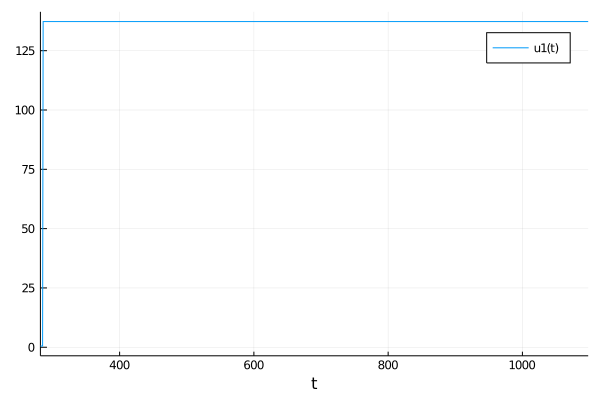

In [230]:
plot(sol_backward)